Linked Notebooks:
<br>
1. Problem on Negative Units Sold Difference: <br>
https://colab.research.google.com/drive/1dpvkWPKPoRmGDRERh4CWUssP9n58y5Ol?usp=sharing

### Notes:

1. Create a transformation pipeline for prediction. Transform X features similar
to trained X data.
2. Hyperopt, for hyperparameter tuning.
3. Add a auto-learn and auto build feature.

In [4]:
!pip install pyjanitor --quiet
!pip install --upgrade pandas-flavor --quiet
# !pip install shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 kB 3.8 MB/s eta 0:00:00a 0:00:01


In [24]:
from prepare_analytics import *
import pandas as pd
import numpy as np

from plotnine import *
import janitor
import janitor.ml
import pandas_flavor as pf
import warnings
import missingno as mnso
from scipy.stats import zscore
import pandas_flavor as pf

from google.colab import data_table
data_table.disable_dataframe_formatter()


warnings.filterwarnings(action='ignore')
pd.options.display.max_columns=50

# read dataframe
pep = pd.read_csv('client_pepsi_coke.csv', index_col=0)

#### Preprocessing

In [25]:
@pf.register_dataframe_method
def create_price_before_discount(df):
    """

    """

    price_before_discount_clean = []
    for i in df.price_before_discount:
        if i == '':
            price_before_discount_clean.append(np.nan)
        else:
            price_before_discount_clean.append(i)

    # copy price_before_discount before fill zero
    discount = df.price_before_discount.copy()

    # get index
    discount_not_na = discount[discount.notna()].index
    discount[discount_not_na] = 1
    discount = discount.fillna(0)
    discount = discount.astype('object')

    new_columns = {
        'is_discount' : discount,
        'price_before_discount': pd.Series(
        price_before_discount_clean, dtype='float')}

    df.assign(**new_columns)

    return df

@pf.register_dataframe_method
def update_bool_to_int(df):
    """
    """
    bool_features = df.select_dtypes('bool').columns
    df[bool_features] = df.select_dtypes('bool').astype('int')

    return df

@pf.register_dataframe_method
def select_training_features(df):
    """
    """
    features = [
        'date', 'product_name', 'pack_size',
        'pack_type', 'name', 'price_median',
        'raw_discount', 'price_before_discount',
        'low_price_guarantee', 'can_use_cod',
        'units_sold_diff', 'month', 'day', 'sales']

    df = df[features]\
        .reorder_columns(['date', 'month', 'day'])

    return df

@pf.register_dataframe_method
def drop_constant_feat_for_pred(df):
    """
    """

    const = ['pack_size', 'pack_type', 'name']
    df = df.drop(const, axis=1)

    return df

@pf.register_dataframe_method
def fix_units_negative(df)\
        -> pd.DataFrame:
    """
        Fix the negative units sold diff. due to refunds or take backs of orders.
    :return: An appeneded new series to the df. Which is a boolean indicator
     to identify dates where refunds > units_sold.
    :rtype: pd.DataFrame
    """
    # get entries' index with negative value
    index_neg_units_sold_diff = df.filter_on("units_sold_diff < 0").index

    # create function to return 1
    fill_index_neg_bool = lambda x: 1 if x in index_neg_units_sold_diff else 0

    # map function to dataframe
    fill_index_neg_bool_series = pd.Series(
        df.index.map(fill_index_neg_bool).to_list())

    # set default value of units sold diff to 0
    df.loc[index_neg_units_sold_diff, 'units_sold_diff'] = 0

    # create refund series from mapped data
    df['refund'] = fill_index_neg_bool_series

    return df

In [26]:
@pf.register_dataframe_method
def fix_sales_negative(df)\
        -> pd.DataFrame:
    """
        Fix the negative sales from negative units.
        due to refunds or take backs of orders.
    :return: Returns a dataframe with clean sales (without negatives)
    :rtype: pd.DataFrame
    """
    # get entries' index with negative value
    index_neg_sales_diff = df.filter_on("sales < 0").index

    # create function to return 1
    fill_index_neg_bool = lambda x: 1 if x in index_neg_sales_diff else 0

    # set default value of units sold diff to 0
    df.loc[index_neg_sales_diff, 'sales'] = 0

    return df

### Create product name
- This step is int the automated process but was applied on the later data.

In [27]:
# filter column by brand Pepsi and coke
pepsi = pep.filter_column_isin('brand', ['Pepsi'])
coke = pep.filter_column_isin('brand', ['Coca-Cola'])

# map name column to extract products (more simplified and atomic)
pepsi_products = ["Regular Soda", "Black"]
df_filtered = pepsi[pepsi.name.str.contains('Pepsi')].reset_index(drop=True)
df_filtered['product_name'] = [pepsi_products[0] if re.search(
    pepsi_products[0], i) else "Pepsi Black" for i in df_filtered.name]

pepsi = df_filtered

# concat and drop index
pep_ml = pd.concat([pepsi, coke]).reset_index(drop=True)

### Create Sales

In [28]:
# create sales feature
pep_ml['sales'] = pep_ml.price_median * pep_ml.units_sold_diff

### Fix Units Sold difference negative entries.

In [29]:
pep_ml = pep_ml\
    .fix_units_negative()\
    .fix_sales_negative()

In [30]:
pep_ml = pep_ml\
    .create_price_before_discount()\
    .update_bool_to_int()\
    .select_training_features()

#### Numerical Features

The y-class has outliers, it's either we impute the outliers or let it pass to training.

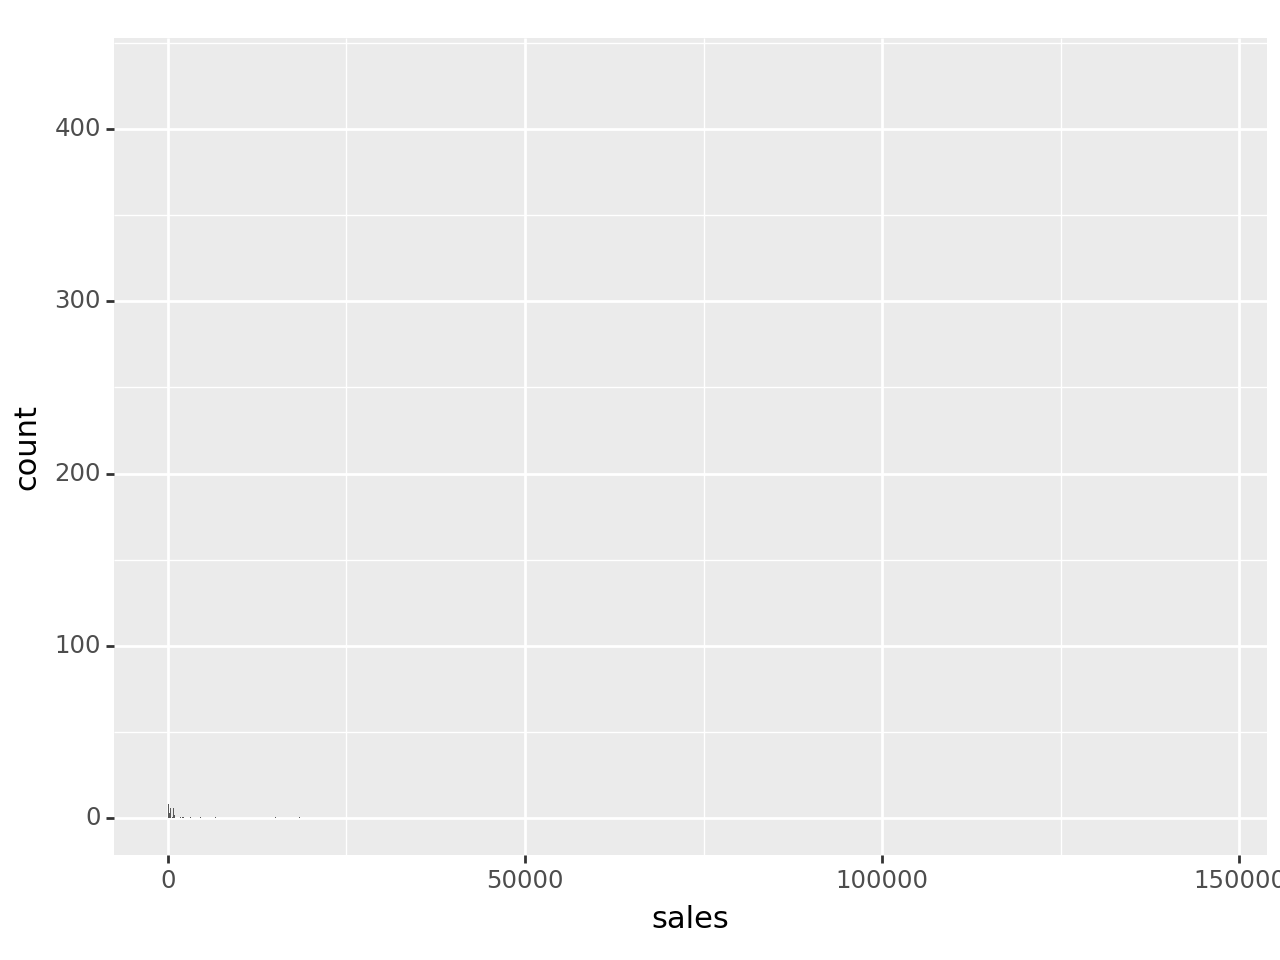

<Figure Size: (640 x 480)>

In [12]:
ggplot(pep_ml)\
    + geom_histogram(aes('sales'))

In [31]:
np.round(pep_ml.sales.describe().to_frame()).T

,count,mean,std,min,25%,50%,75%,max
sales,687.0,837.0,6805.0,0.0,0.0,0.0,132.0,146538.0


In [32]:
pep_ml_drop = pep_ml.dropna(subset='units_sold_diff').reset_index(drop=True)
pep_ml_drop['units_sold_diff'] = pep_ml_drop.units_sold_diff.astype('int')
non_zero_units_sold = pep_ml_drop[pep_ml_drop.units_sold_diff != 0]\
    .reset_index(drop=True)

In [33]:
# z-score outlier detection
z_scores = zscore(non_zero_units_sold.units_sold_diff)
threshold = 2
outliers = np.where(np.abs(z_scores) > threshold)
non_zero_units_sold  = non_zero_units_sold.drop(outliers[0], axis=0)

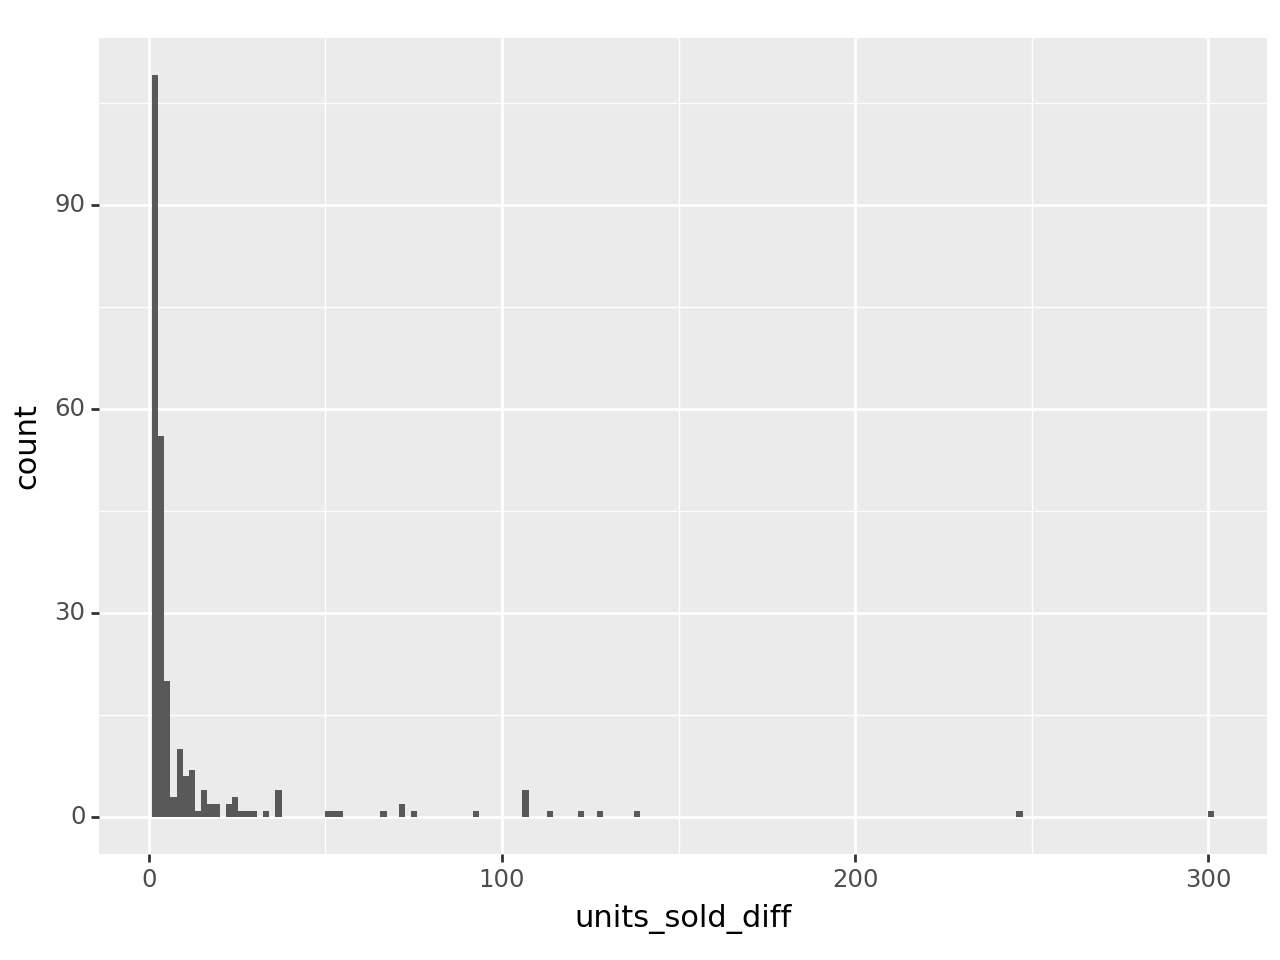

<Figure Size: (640 x 480)>

In [34]:
ggplot(non_zero_units_sold) \
    + geom_histogram(aes('units_sold_diff'))

#### Feature Engineering

In [35]:
pep_ml['date'] = pd.to_datetime(pep_ml.date)

In [36]:
pep_ml['week'] = pep_ml.date.dt.week
pep_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   706 non-null    datetime64[ns]
 1   month                  706 non-null    object        
 2   day                    706 non-null    int64         
 3   product_name           706 non-null    object        
 4   pack_size              706 non-null    object        
 5   pack_type              706 non-null    object        
 6   name                   706 non-null    object        
 7   price_median           706 non-null    int64         
 8   raw_discount           706 non-null    int64         
 9   price_before_discount  57 non-null     float64       
 10  low_price_guarantee    706 non-null    int64         
 11  can_use_cod            706 non-null    int64         
 12  units_sold_diff        687 non-null    float64       
 13  sales

#### Drop date feature

In [37]:
pep_ml = pep_ml.drop('date', axis=1)

### Modeling

1. Choose a validation set, training set, and test set.
2. Use a model that is robust to outliers.
> Tree-based Regressors, or boosting models.
3. The metric should be accuracy and precision
4. The model should explainable.

In [39]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Date masking

In [40]:
pep_ml_sept_oct = pep_ml.filter_column_isin('month', ['September', 'October']).reset_index(drop=True)

Product masking

In [42]:
regular_soda = pep_ml_sept_oct.filter_column_isin('product_name', ['Regular Soda']).reset_index(drop=True)

Select features & prepare features

In [43]:
X, y = regular_soda.get_features_targets('sales')

# select and change astyle of int to cat
num_cat_feat = ['day', 'low_price_guarantee','week']
X = X.change_type(num_cat_feat, dtype='object')

In [44]:
# units sold to be 0 instead of NaN
X.units_sold_diff = X.units_sold_diff.fillna(0)

# create discount

discount = X.price_before_discount.copy()
discount_not_na = discount[discount.notna()].index
discount[discount_not_na] = 1
discount = discount.fillna(0)
discount = discount.astype('object')
X['is_discounted'] = discount

In [ ]:
def create_price_before_discount_bool(df):

    # copy price_before_discount before fill zero
    discount = df.price_before_discount.copy()

    # get index
    discount_not_na = discount[discount.notna()].index
    discount[discount_not_na] = 1
    discount = discount.fillna(0)
    discount = discount.astype('object')

    new_columns = {'is_discount' : discount}
    df.assign(**new_columns)


In [45]:
# nan index
index_price_before = X[X.price_before_discount.isna()].index

X.price_before_discount.iloc[index_price_before] = X.price_median\
    .iloc[index_price_before]

#### Choose one product for training

Column Transformer

In [46]:
def transform_column(X, number_names: list, object_names: list)\
-> pd.DataFrame():
    """
    :description:
        Column transformer function
    :X: contains x features for training data.
    :X type: pd.DataFrame
    :number_names: List names of numerical features to be transformed.
    :number_names type: List
    :object_names: List names of object features to be transformed.
    :object_names type: List
    """
    ct = make_column_transformer(
        (StandardScaler(), number_names),
        (OneHotEncoder(), object_names))

    X_transformed = ct.fit_transform(X).toarray()

    # get labels from one hot encoder
    encoded_feat_names = ct.named_transformers_['onehotencoder']\
        .get_feature_names_out()

    all_feat = number_names
    all_feat.extend(encoded_feat_names)

    X_ct = pd.DataFrame(X_transformed, columns=all_feat)

    return X_ct

In [47]:
x_num_names = X.select_dtypes('number').columns.to_list()
x_obj_names = X.select_dtypes('object').columns.to_list()

Transform

In [48]:
x_num_names = X.select_dtypes('number')\
    .columns.to_list()
x_obj_names = X.select_dtypes('object')\
    .columns.to_list()

In [49]:
tdf = transform_column(X, x_num_names, x_obj_names)

### Build a model

In [50]:
!pip install shap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.5 MB/s eta 0:00:00a 0:00:01


In [51]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, accuracy_score,\
    precision_score, mean_squared_error

from sklearn.model_selection import cross_val_score

import shap

In [52]:
def get_cvs_score(model, scoring: str, cv=5) -> None:
    scores = cross_val_score(model, tdf, y, cv=cv, scoring=scoring)
    for i, score in enumerate(scores):
        print(i, score)

In [53]:
lm = LinearRegression()
get_cvs_score(model=lm, scoring='r2')

0 -1.788932599128148e+16
1 -1.983243182606101e+23
2 -1.5539546566585333e+23
3 -1.342555871070716e+21
4 -8.023873213768075e+24


In [54]:
rfr = RandomForestRegressor(random_state=5)

In [55]:
get_cvs_score(rfr, scoring='r2')

0 -0.058715531736898585
1 -110.33340249724033
2 -0.3953715674570366
3 0.9924741780762187
4 0.999958307374742


train test split

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    tdf, y, train_size=.8, random_state=5)

In [58]:
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=5)

In [59]:
y_pred = rfr.predict(X_test)

In [60]:
r2_score(y_pred, y_test)

0.653623234212061

In [61]:
xgbr = XGBRegressor()

In [62]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [63]:
y_pred = xgbr.predict(X_test)

In [64]:
r2_score(y_pred, y_test)

0.9099632433224916

In [65]:
import pickle

with open('xgbr_pep_co.pickle', 'wb') as f:
    pickle.dump(xgbr, f)

#### Results

The problem with this model is that it uses different products to predict the
units sold. Therefore the 800g Oatmeal is the highest predictor of units sold. We have to separate the product in terms of training data. If we seperate the training data by product then we'll have less data for our
training model.

However, we'll have multiple models trained for each product. We can do a test
to train 1 product and see the results. As to feature importances.